In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from backtesting import Strategy
from backtesting import Backtest
from sklearn.model_selection import ParameterGrid
import multiprocessing as mp
import matplotlib.pyplot as plt
if mp.get_start_method(allow_none=True) != 'fork':
    mp.set_start_method('fork', force=True)
    
    
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap

from backtesting import Strategy
from backtesting import Backtest

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getYFinanceData(ticker, period, interval):
  dataF = yf.download(ticker, period=period, interval=interval)

  dataF.iloc[:,:]
  #dataF.Open.iloc

  df = pd.DataFrame(dataF)

  # use df index, convert DateTime to  a column instead of index
  df.reset_index(inplace=True)

  # delete Adj Close
  df = df.drop(['Adj Close'], axis=1)

  # rename Datetime to "Gmt time"
  df = df.rename(columns={'Datetime':'Gmt time'})
  
  # rename Date to "Gmt time"
  df = df.rename(columns={'Date':'Gmt time'})

  df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
  df.set_index("Gmt time", inplace=True)
  df=df[df.High!=df.Low]

  return df

In [3]:
# test results

testResults = dict()

#### Maximize Sharpe Ratio, Close when all trades become positive

[*********************100%***********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-07-27 00:00...
End                       2024-12-05 15:00...
Duration                    862 days 16:00:00
Exposure Time [%]                   99.985315
Equity Final [$]               1012809.933228
Equity Peak [$]                1133172.675415
Return [%]                         237.603311
Buy & Hold Return [%]               54.941909
Return (Ann.) [%]                   52.997795
Volatility (Ann.) [%]               55.532575
Sharpe Ratio                         0.954355
Sortino Ratio                        2.466644
Calmar Ratio                         1.946693
Max. Drawdown [%]                  -27.224521
Avg. Drawdown [%]                   -1.196662
Max. Drawdown Duration       87 days 14:00:00
Avg. Drawdown Duration        2 days 19:00:00
# Trades                                  552
Win Rate [%]                         96.73913
Best Trade [%]                      12.592063
Worst Trade [%]                     -5.236653
Avg. Trade [%]                    

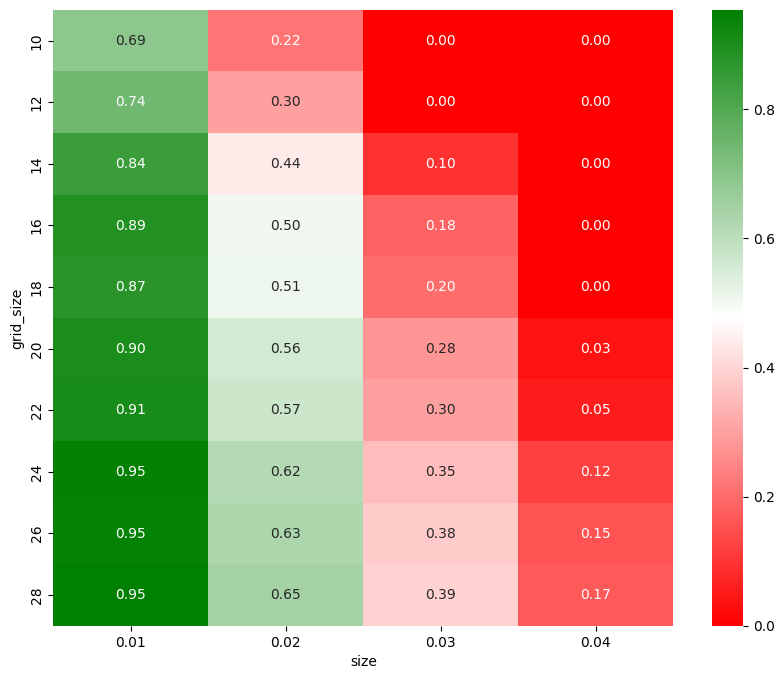

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1807975149.py:66: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


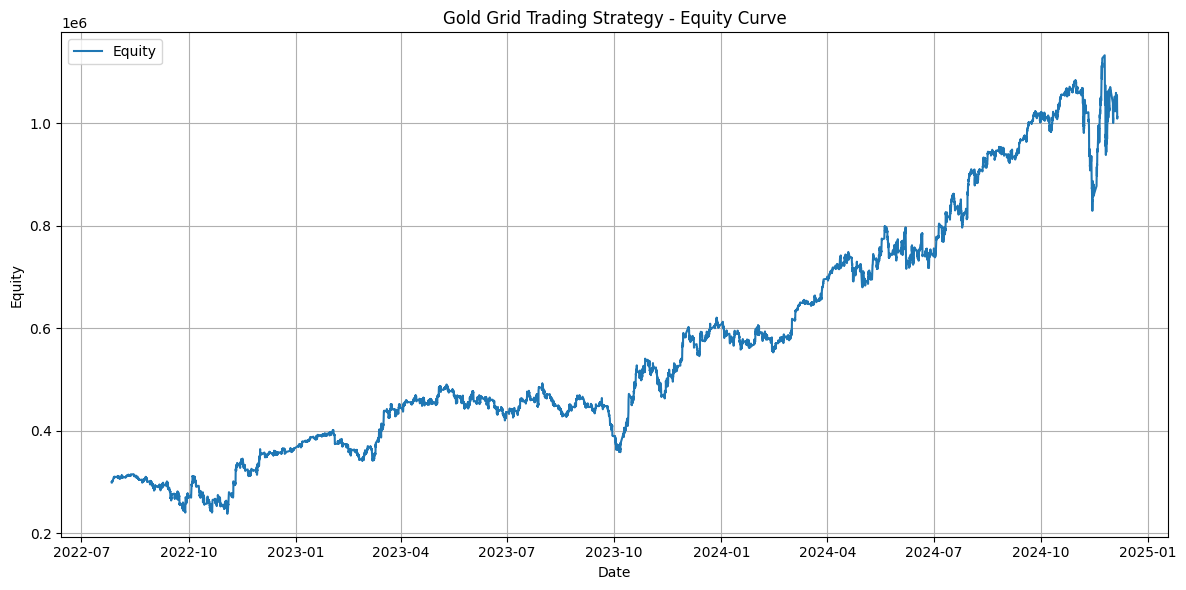

In [30]:
strategyName = "GC=F_maximize-sharpe_all-breakeven"
df = getYFinanceData("GC=F", "720d", "1h")

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class GoldGridTrading(Strategy):
    grid_size = 20  # Grid size in dollars
    size=0.01
    
    def init(self):
        super().init()
        self.last_buy_price = None

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.grid_size:
            self.buy(size=self.size)  # Buy 0.01 lots of gold
            self.last_buy_price = current_price
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        all_trades_profitable = all(trade.pl_pct > 0 for trade in self.trades)
        
        if (
            # (total_profit > 0) or
            (all_trades_profitable) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None

# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              grid_size=[i for i in range(10, 30, 2)],
                              size=[i/100 for i in range(1, 5, 1)],
                              maximize='Sharpe Ratio', max_tries=100,
                              random_state=0,
                              return_heatmap=True
                            )

testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.grid_size,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Minimize Avg. Drawdown [%], Close when all trades become positive

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-07-27 00:00...
End                       2024-12-05 15:00...
Duration                    862 days 16:00:00
Exposure Time [%]                   99.985315
Equity Final [$]                 731297.18335
Equity Peak [$]                 785501.637451
Return [%]                         143.765728
Buy & Hold Return [%]               54.941909
Return (Ann.) [%]                   36.429004
Volatility (Ann.) [%]               34.718797
Sharpe Ratio                         1.049259
Sortino Ratio                        2.345375
Calmar Ratio                         1.685428
Max. Drawdown [%]                   -21.61409
Avg. Drawdown [%]                   -0.966886
Max. Drawdown Duration       87 days 15:00:00
Avg. Drawdown Duration        3 days 02:00:00
# Trades                                  522
Win Rate [%]                        96.934866
Best Trade [%]                      11.238681
Worst Trade [%]                     -5.236653
Avg. Trade [%]                    

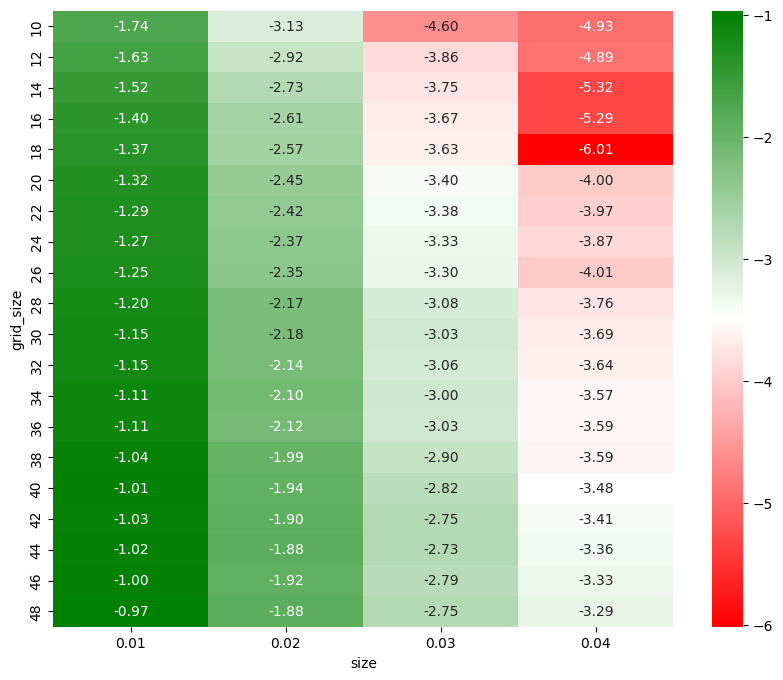

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1749656198.py:66: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


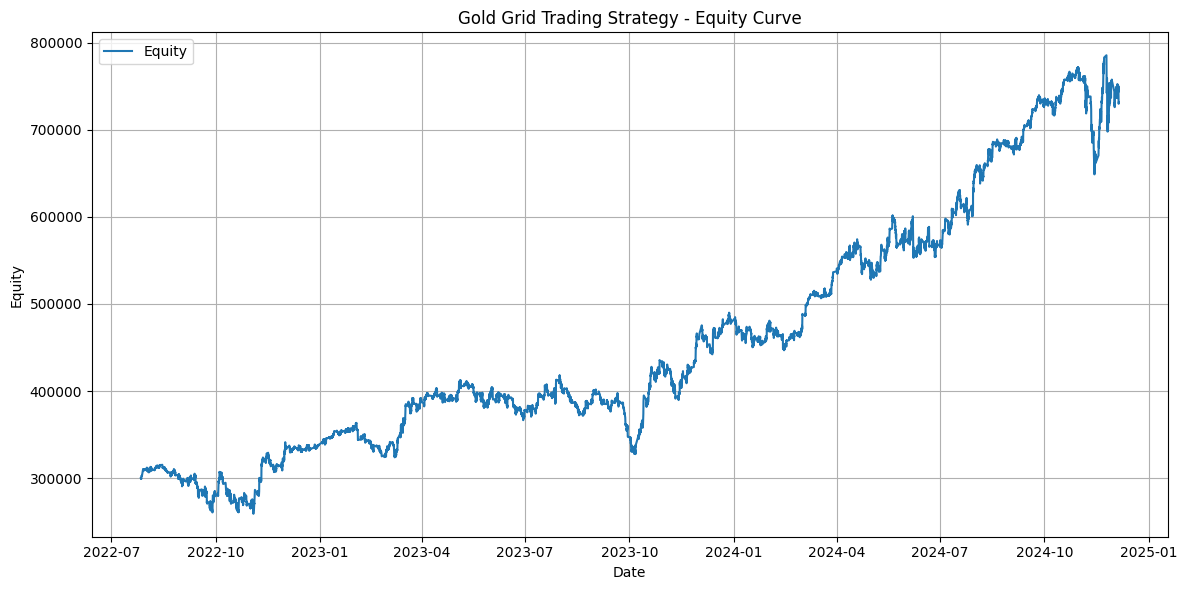

In [31]:
strategyName = "GC=F_minimize-drawdown_all-profitable"
df = getYFinanceData("GC=F", "720d", "1h")

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class GoldGridTrading(Strategy):
    grid_size = 20  # Grid size in dollars
    size=0.01
    
    def init(self):
        super().init()
        self.last_buy_price = None

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.grid_size:
            self.buy(size=self.size)  # Buy 0.01 lots of gold
            self.last_buy_price = current_price
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        all_trades_profitable = all(trade.pl_pct > 0 for trade in self.trades)
        
        if (
            # (total_profit > 0) or
            (all_trades_profitable) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None

# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              grid_size=[i for i in range(10, 50, 2)],
                              size=[i/100 for i in range(1, 5, 1)],
                              maximize='Avg. Drawdown [%]', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )

testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.grid_size,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Maximize Sharpe Ratio, Close when all trade become net positive equal to 0.01 lot

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-07-27 00:00...
End                       2024-12-05 15:00...
Duration                    862 days 16:00:00
Exposure Time [%]                   99.985315
Equity Final [$]                577571.981445
Equity Peak [$]                 584698.191895
Return [%]                          92.523994
Buy & Hold Return [%]               54.930236
Return (Ann.) [%]                    25.70362
Volatility (Ann.) [%]               20.070471
Sharpe Ratio                         1.280668
Sortino Ratio                        2.758367
Calmar Ratio                         2.055282
Max. Drawdown [%]                  -12.506128
Avg. Drawdown [%]                   -0.578458
Max. Drawdown Duration       85 days 11:00:00
Avg. Drawdown Duration        2 days 16:00:00
# Trades                                   98
Win Rate [%]                        82.653061
Best Trade [%]                       6.260369
Worst Trade [%]                     -3.584372
Avg. Trade [%]                    

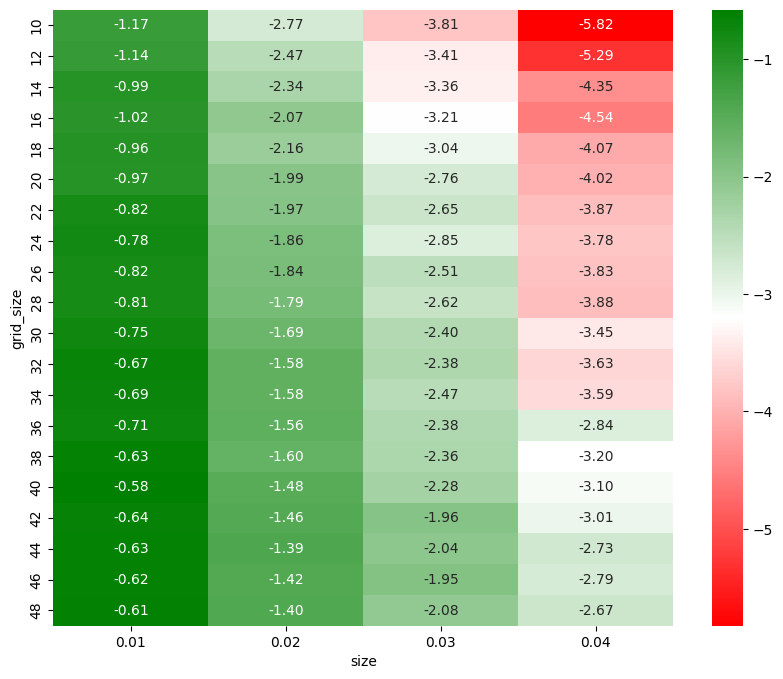

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1316845069.py:69: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


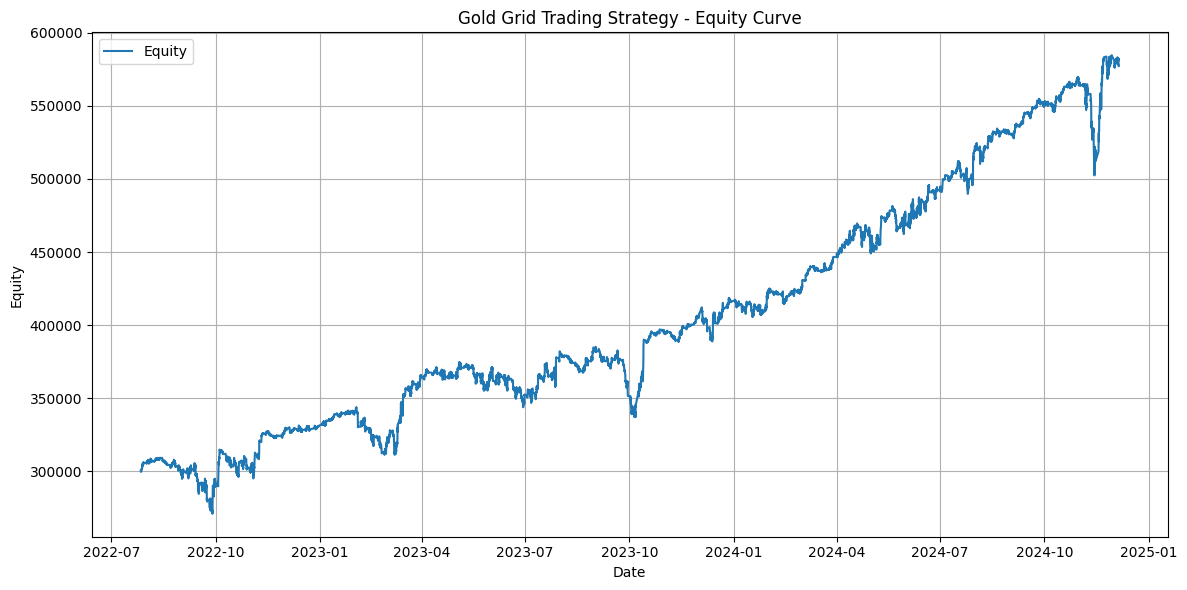

In [32]:
strategyName = "GC=F_maximize-sharpe_net-profitable"
df = getYFinanceData("GC=F", "720d", "1h")

dfopt = df[:]
def SIGNAL():
    return dfopt.TotalSignal

class GoldGridTrading(Strategy):
    grid_size = 20  # Grid size in dollars
    size=0.01
    
    def init(self):
        super().init()
        self.last_buy_price = None

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.grid_size:
            self.buy(size=self.size)  # Buy 0.01 lots of gold
            self.last_buy_price = current_price
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        all_trades_profitable = all(trade.pl_pct > 0 for trade in self.trades)
        
        if (
            (
              total_profit > self.size * len(self.trades) and
              len(self.trades) > 1
            ) or
            # (all_trades_profitable) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None

# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              grid_size=[i for i in range(10, 50, 2)],
                              size=[i/100 for i in range(1, 5, 1)],
                              maximize='Avg. Drawdown [%]', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )

testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.grid_size,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Increase the grid_size during downtrend

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-07-27 00:00...
End                       2024-12-05 15:00...
Duration                    862 days 16:00:00
Exposure Time [%]                   99.985315
Equity Final [$]                529975.352905
Equity Peak [$]                 539732.267212
Return [%]                          76.658451
Buy & Hold Return [%]               54.930236
Return (Ann.) [%]                   21.955698
Volatility (Ann.) [%]               18.741969
Sharpe Ratio                         1.171472
Sortino Ratio                        2.339174
Calmar Ratio                          1.56055
Max. Drawdown [%]                  -14.069208
Avg. Drawdown [%]                   -0.625877
Max. Drawdown Duration       88 days 15:00:00
Avg. Drawdown Duration        3 days 00:00:00
# Trades                                   83
Win Rate [%]                        81.927711
Best Trade [%]                       6.816499
Worst Trade [%]                     -3.300077
Avg. Trade [%]                    

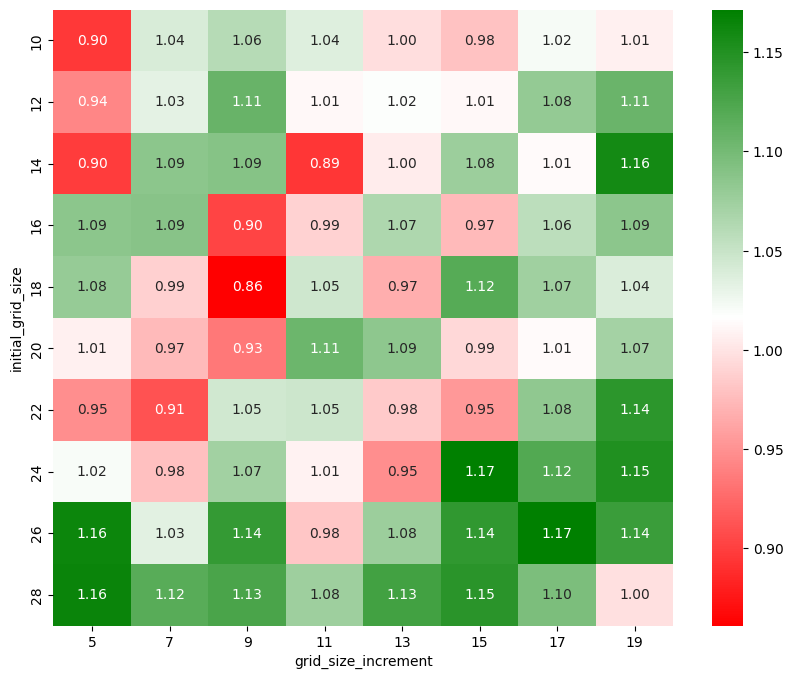

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/2528884914.py:71: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


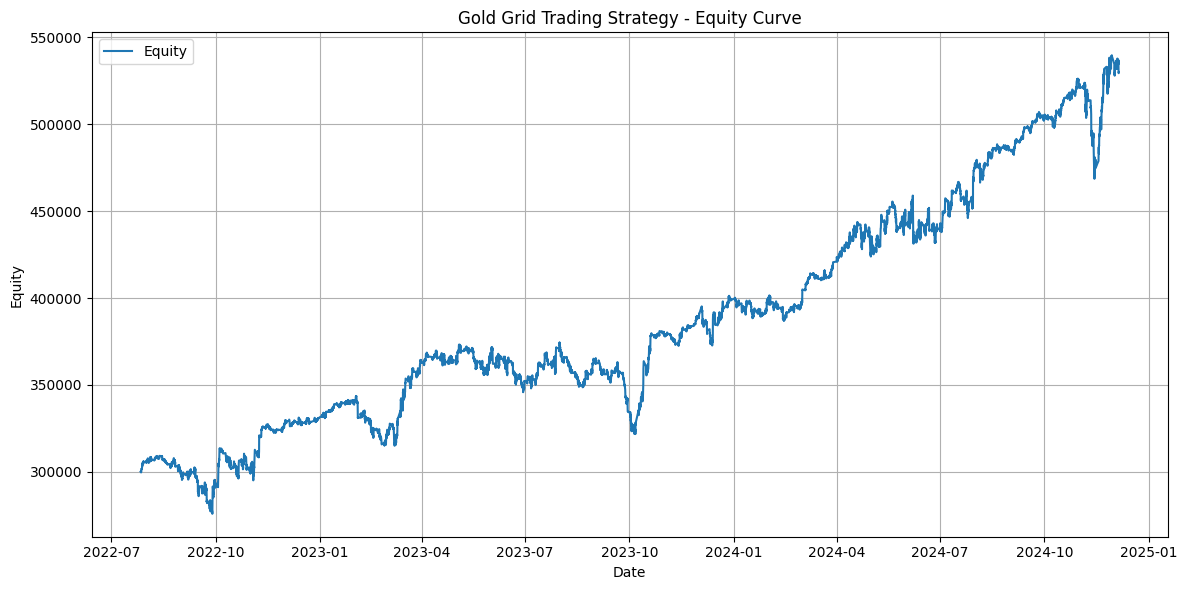

In [33]:
strategyName = "GC=F_maximize-sharpe_net-profitable_increasing-grid-size"
df = getYFinanceData("GC=F", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * self.unprofitable_trades)
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            self.buy(size=self.size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        
        if (
            (total_profit > self.size * len(self.trades) and len(self.trades) > 1) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(10, 30, 2)],
                              grid_size_increment = [i for i in range(5, 20, 2)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term

[*********************100%***********************]  1 of 1 completed


Start                     2018-05-10 00:00:00
End                       2024-12-05 00:00:00
Duration                   2401 days 00:00:00
Exposure Time [%]                   99.870634
Equity Final [$]                790318.533813
Equity Peak [$]                 790318.533813
Return [%]                         163.439511
Buy & Hold Return [%]              100.923679
Return (Ann.) [%]                   17.103947
Volatility (Ann.) [%]               24.149942
Sharpe Ratio                          0.70824
Sortino Ratio                        1.338729
Calmar Ratio                         0.558419
Max. Drawdown [%]                  -30.629236
Avg. Drawdown [%]                   -1.705002
Max. Drawdown Duration      246 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                  188
Win Rate [%]                         72.87234
Best Trade [%]                      11.153936
Worst Trade [%]                     -6.655876
Avg. Trade [%]                    

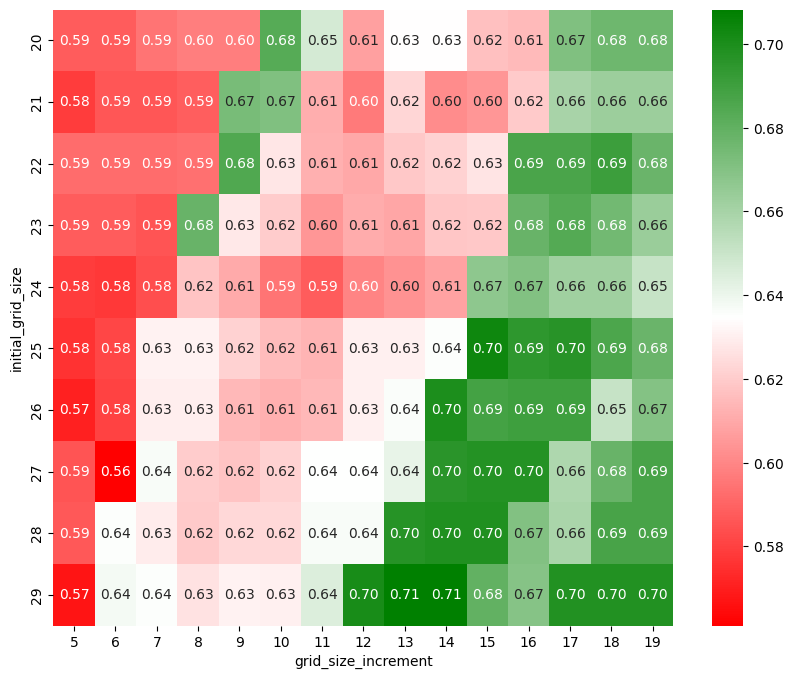

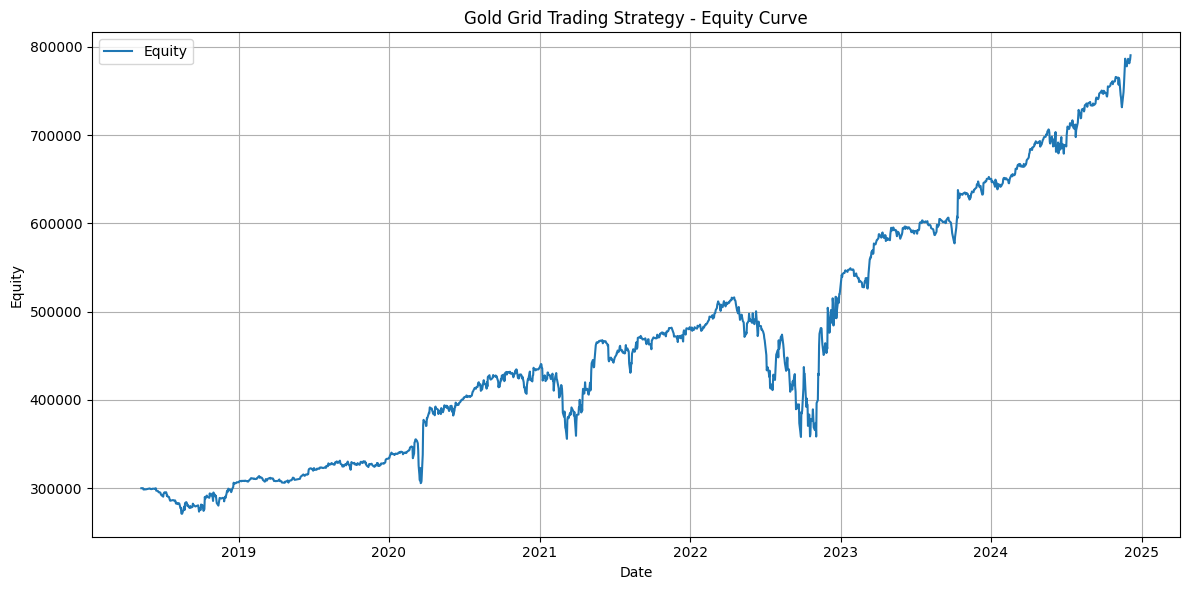

In [34]:
import math

strategyName = "GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("GC=F", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.02  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/20)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(20, 30, 1)],
                              grid_size_increment = [i for i in range(5, 20, 1)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SPX

[*********************100%***********************]  1 of 1 completed


Start                     2016-12-23 00:00:00
End                       2024-12-05 00:00:00
Duration                   2904 days 00:00:00
Exposure Time [%]                        99.9
Equity Final [$]                 878135.14209
Equity Peak [$]                  878135.14209
Return [%]                         192.711714
Buy & Hold Return [%]              168.649911
Return (Ann.) [%]                   14.491027
Volatility (Ann.) [%]                28.78988
Sharpe Ratio                         0.503338
Sortino Ratio                        0.916487
Calmar Ratio                         0.406079
Max. Drawdown [%]                  -35.685257
Avg. Drawdown [%]                   -1.255215
Max. Drawdown Duration      210 days 00:00:00
Avg. Drawdown Duration       13 days 00:00:00
# Trades                                   65
Win Rate [%]                        72.307692
Best Trade [%]                      12.326707
Worst Trade [%]                     -8.211774
Avg. Trade [%]                    

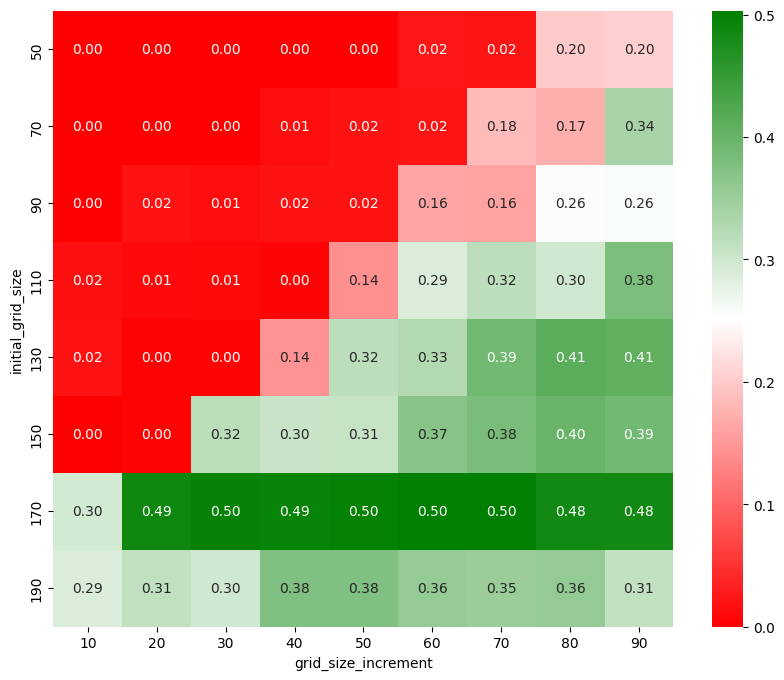

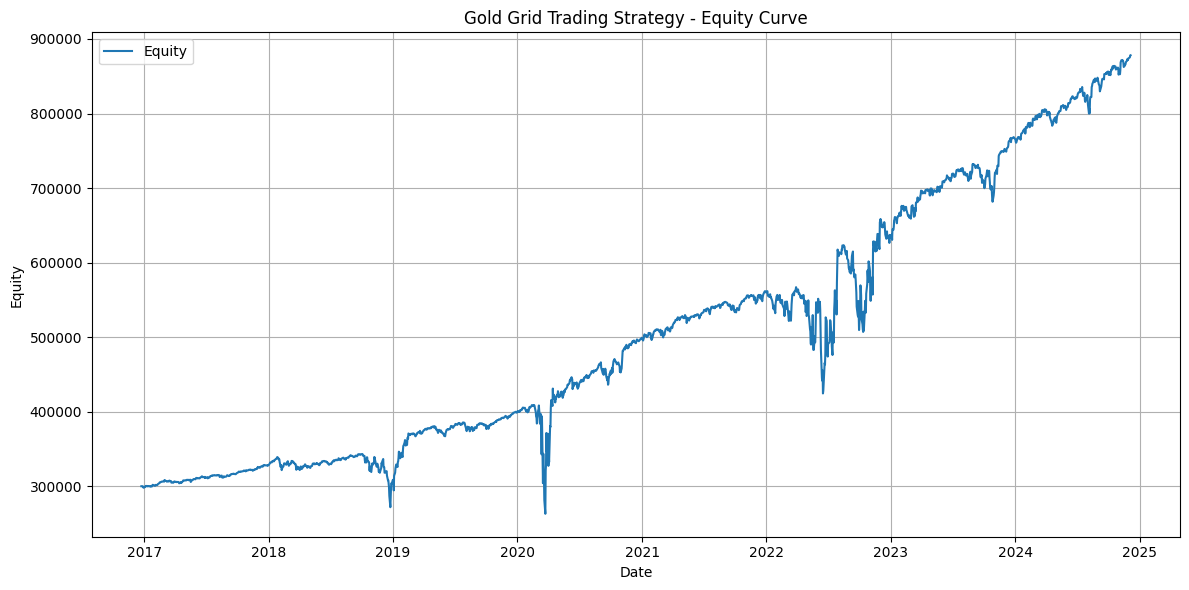

In [35]:
import math

strategyName = "^SPX_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("^SPX", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -1, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-1, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(50, 200, 20)],
                              grid_size_increment = [i for i in range(10, 100, 10)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_mid-term

[*********************100%***********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-07-27 00:00...
End                       2024-12-05 15:00...
Duration                    862 days 16:00:00
Exposure Time [%]                   99.985315
Equity Final [$]               1417039.241943
Equity Peak [$]                1431350.468018
Return [%]                         372.346414
Buy & Hold Return [%]               54.936065
Return (Ann.) [%]                   72.090621
Volatility (Ann.) [%]               62.503193
Sharpe Ratio                         1.153391
Sortino Ratio                         3.62657
Calmar Ratio                         2.812042
Max. Drawdown [%]                  -25.636395
Avg. Drawdown [%]                   -1.123722
Max. Drawdown Duration       77 days 05:00:00
Avg. Drawdown Duration        2 days 07:00:00
# Trades                                  263
Win Rate [%]                        70.342205
Best Trade [%]                       6.175566
Worst Trade [%]                     -3.320472
Avg. Trade [%]                    

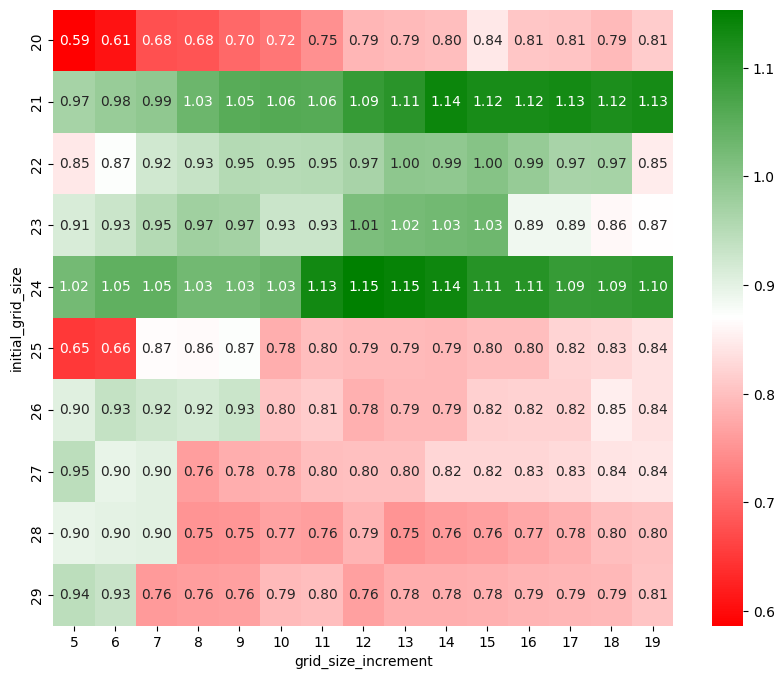

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/3705989395.py:80: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


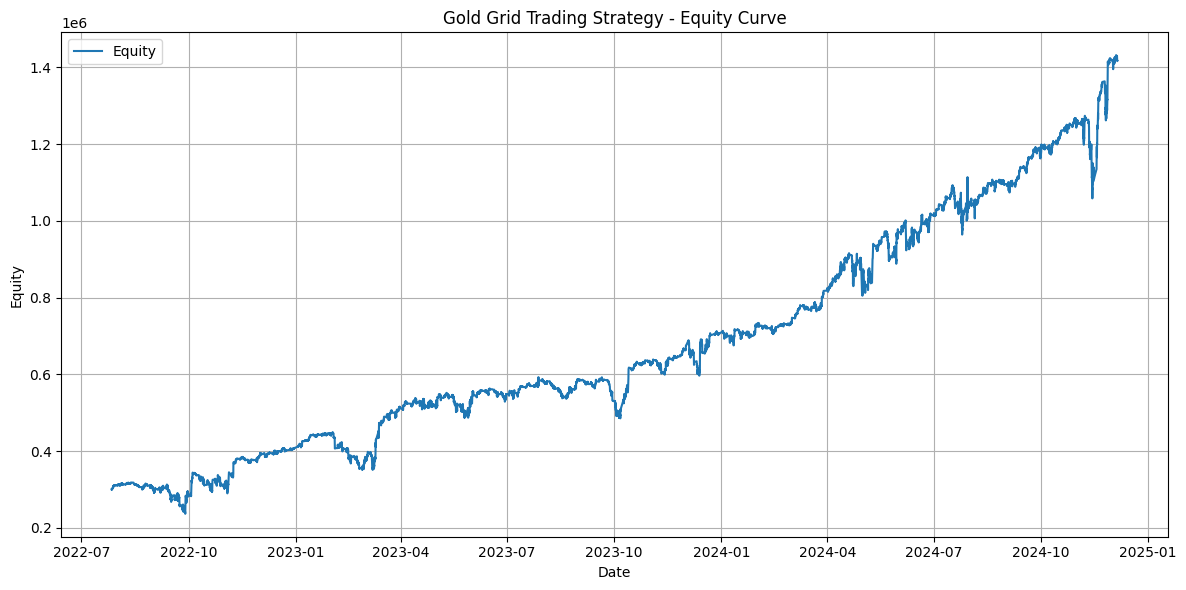

In [36]:
import math

strategyName = "GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_mid-term"
df = getYFinanceData("GC=F", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.02  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(20, 30, 1)],
                              grid_size_increment = [i for i in range(5, 20, 1)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SPX

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-01-26 09:30...
End                       2024-12-05 14:30...
Duration                   1044 days 05:00:00
Exposure Time [%]                   99.960151
Equity Final [$]                446648.718506
Equity Peak [$]                 446978.484131
Return [%]                          48.882906
Buy & Hold Return [%]               38.058928
Return (Ann.) [%]                   15.271887
Volatility (Ann.) [%]               18.826277
Sharpe Ratio                         0.811201
Sortino Ratio                        1.427173
Calmar Ratio                         0.686884
Max. Drawdown [%]                  -22.233574
Avg. Drawdown [%]                   -0.589122
Max. Drawdown Duration      131 days 19:00:00
Avg. Drawdown Duration        5 days 07:00:00
# Trades                                   34
Win Rate [%]                        70.588235
Best Trade [%]                      13.515361
Worst Trade [%]                      -9.20252
Avg. Trade [%]                    

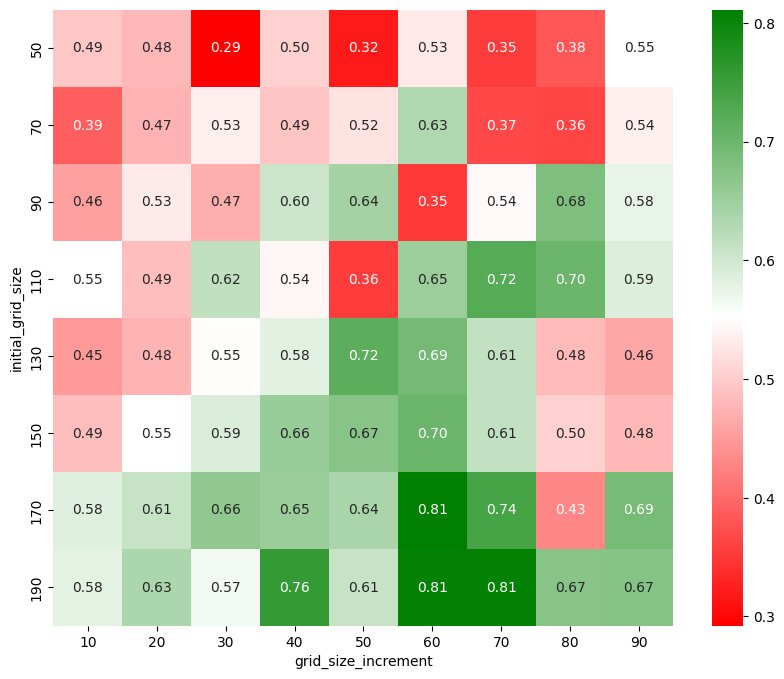

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1025076303.py:71: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


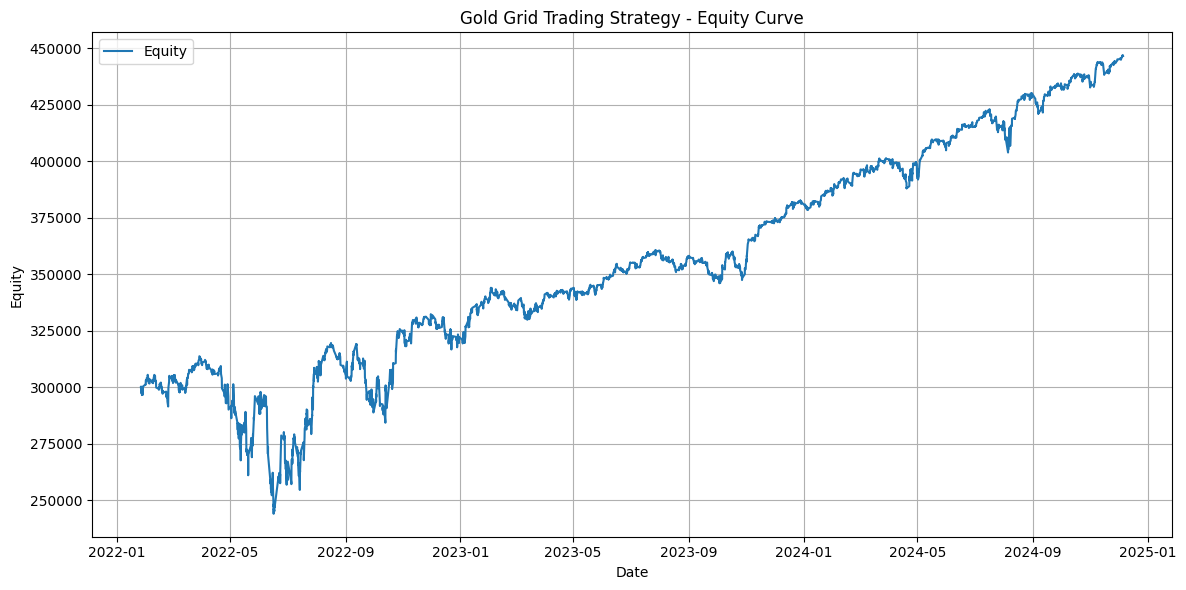

In [37]:
strategyName = "^SPX_maximize-sharpe_net-profitable_increasing-grid-size"
df = getYFinanceData("^SPX", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * self.unprofitable_trades)
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            self.buy(size=self.size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        
        if (
            (total_profit > self.size * len(self.trades) and len(self.trades) > 1) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(50, 200, 20)],
                              grid_size_increment = [i for i in range(10, 100, 10)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### BTC

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-12-19 00:00...
End                       2024-12-07 09:00...
Duration                    719 days 09:00:00
Exposure Time [%]                    99.98836
Equity Final [$]               4010212.046875
Equity Peak [$]                4102065.453125
Return [%]                        1236.737349
Buy & Hold Return [%]              493.965542
Return (Ann.) [%]                  276.780019
Volatility (Ann.) [%]              284.146318
Sharpe Ratio                         0.974076
Sortino Ratio                        7.477832
Calmar Ratio                         5.317436
Max. Drawdown [%]                  -52.051404
Avg. Drawdown [%]                   -2.473112
Max. Drawdown Duration      102 days 03:00:00
Avg. Drawdown Duration        2 days 15:00:00
# Trades                                   51
Win Rate [%]                        68.627451
Best Trade [%]                      32.382598
Worst Trade [%]                     -8.570688
Avg. Trade [%]                    

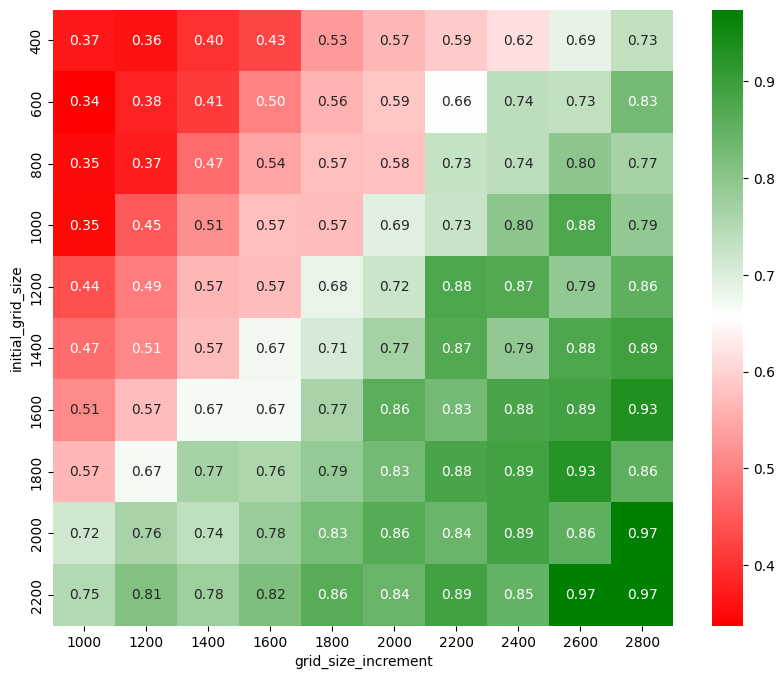

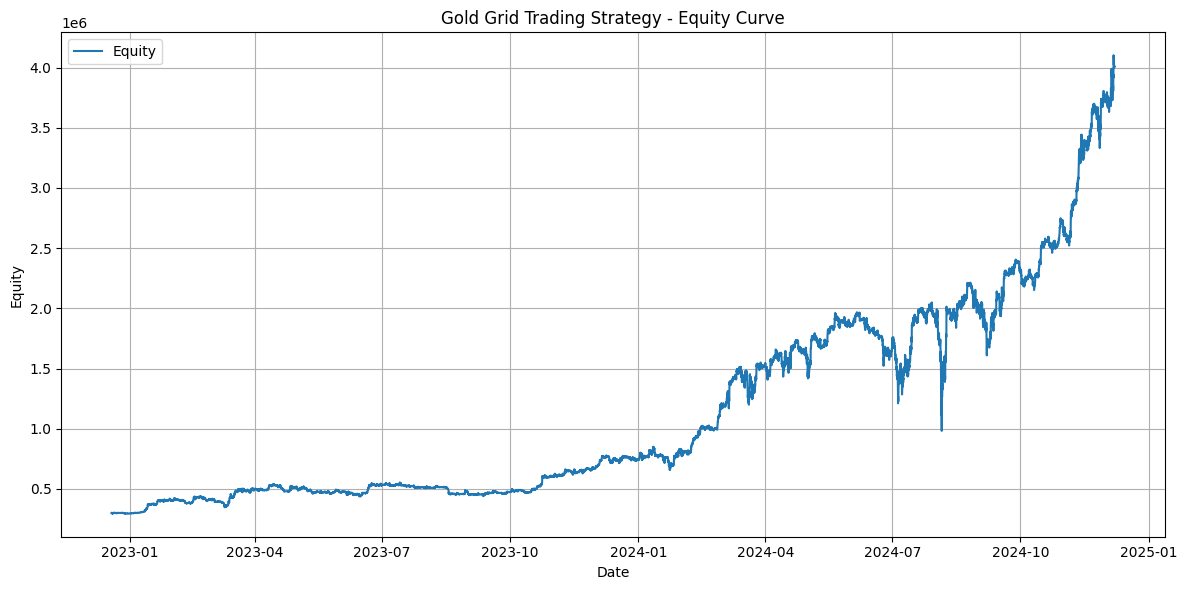

In [19]:
strategyName = "BTC-USD_maximize-sharpe_net-profitable_increasing-grid-size"
df = getYFinanceData("BTC-USD", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 500  # Initial grid size in dollars
    grid_size_increment = 50  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * self.unprofitable_trades)
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            self.buy(size=self.size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        
        if (
            (total_profit > self.size * len(self.trades) and len(self.trades) > 1) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/100)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(400, 2400, 200)],
                              grid_size_increment = [i for i in range(1000, 3000, 200)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### BTC Fixed percentage risk

[*********************100%***********************]  1 of 1 completed

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-12-17 00:00...
End                       2024-12-05 20:00...
Duration                    719 days 20:00:00
Exposure Time [%]                   99.988367
Equity Final [$]               1430992.554688
Equity Peak [$]                1470316.476562
Return [%]                         376.997518
Buy & Hold Return [%]               493.37942
Return (Ann.) [%]                  120.708743
Volatility (Ann.) [%]              113.316919
Sharpe Ratio                         1.065231
Sortino Ratio                        4.364048
Calmar Ratio                         2.979667
Max. Drawdown [%]                  -40.510819
Avg. Drawdown [%]                   -1.336502
Max. Drawdown Duration       98 days 13:00:00
Avg. Drawdown Duration        2 days 02:00:00
# Trades                                  114
Win Rate [%]                        70.175439
Best Trade [%]                      16.607203
Worst Trade [%]                     -9.612565
Avg. Trade [%]                    

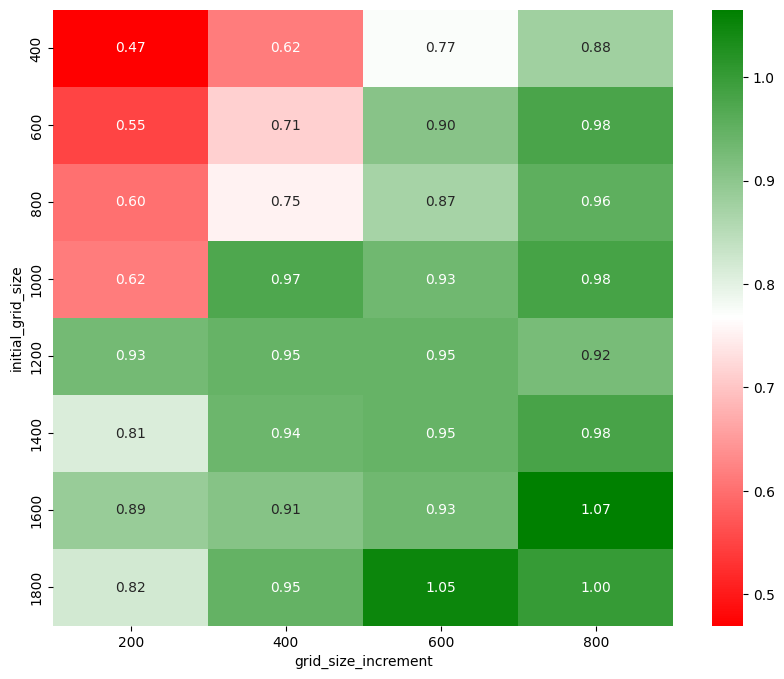

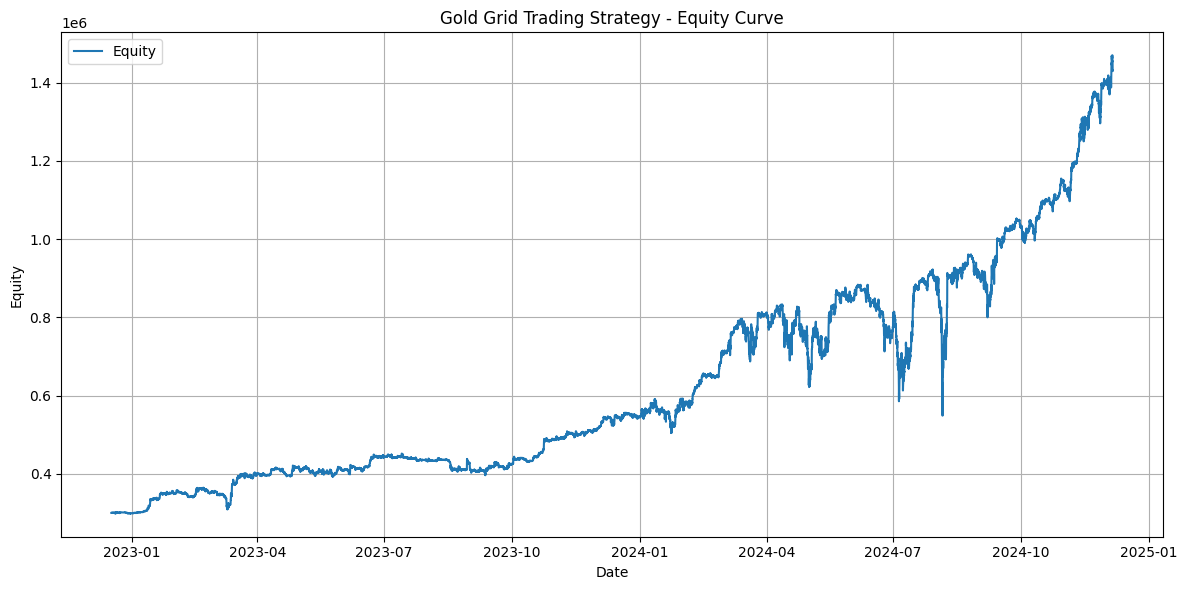

In [39]:
strategyName = "BTC-USD_maximize-sharpe_net-profitable_increasing-grid-size"
df = getYFinanceData("BTC-USD", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 500  # Initial grid size in dollars
    grid_size_increment = 50  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * self.unprofitable_trades)
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            self.buy(size=self.size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        
        if (
            (total_profit > self.size * len(self.trades) and len(self.trades) > 1) or
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(400, 2000, 200)],
                              grid_size_increment = [i for i in range(200, 1000, 200)],
                              maximize='Sharpe Ratio', max_tries=200,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('Gold Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Stocks

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:525: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:526: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:527: FutureWarning: Series.__getitem__ treating keys as pos

Start                     2022-01-26 09:30...
End                       2024-12-05 14:30...
Duration                   1044 days 05:00:00
Exposure Time [%]                   99.960151
Equity Final [$]                  708808.6716
Equity Peak [$]                 898025.629364
Return [%]                         136.269557
Buy & Hold Return [%]               33.511712
Return (Ann.) [%]                   34.766514
Volatility (Ann.) [%]               55.615792
Sharpe Ratio                         0.625119
Sortino Ratio                        1.480308
Calmar Ratio                         1.226308
Max. Drawdown [%]                   -28.35056
Avg. Drawdown [%]                   -2.510186
Max. Drawdown Duration       90 days 00:00:00
Avg. Drawdown Duration        7 days 15:00:00
# Trades                                   72
Win Rate [%]                        68.055556
Best Trade [%]                        7.97742
Worst Trade [%]                    -10.276758
Avg. Trade [%]                    

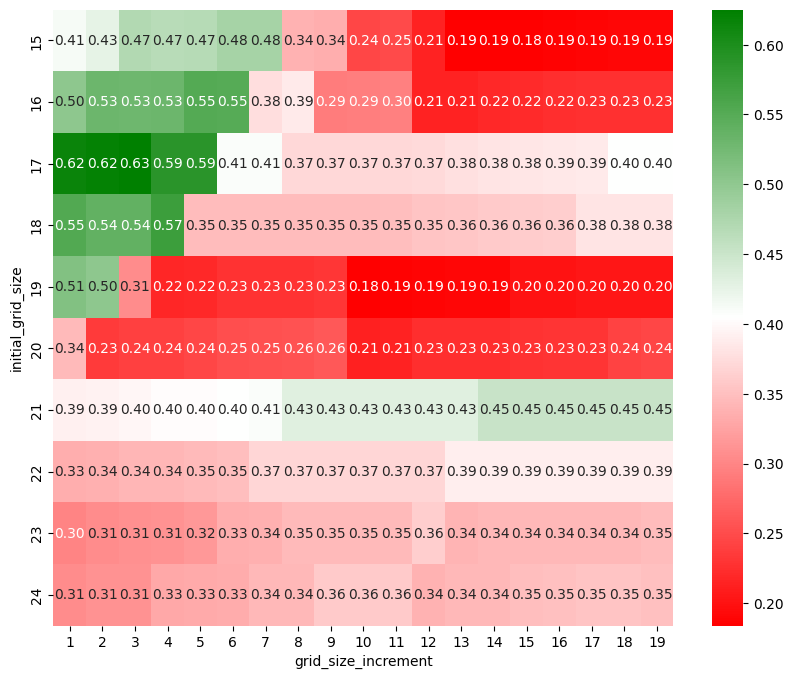

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1952378017.py:80: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot(filename=strategyName+".html", resample=False)


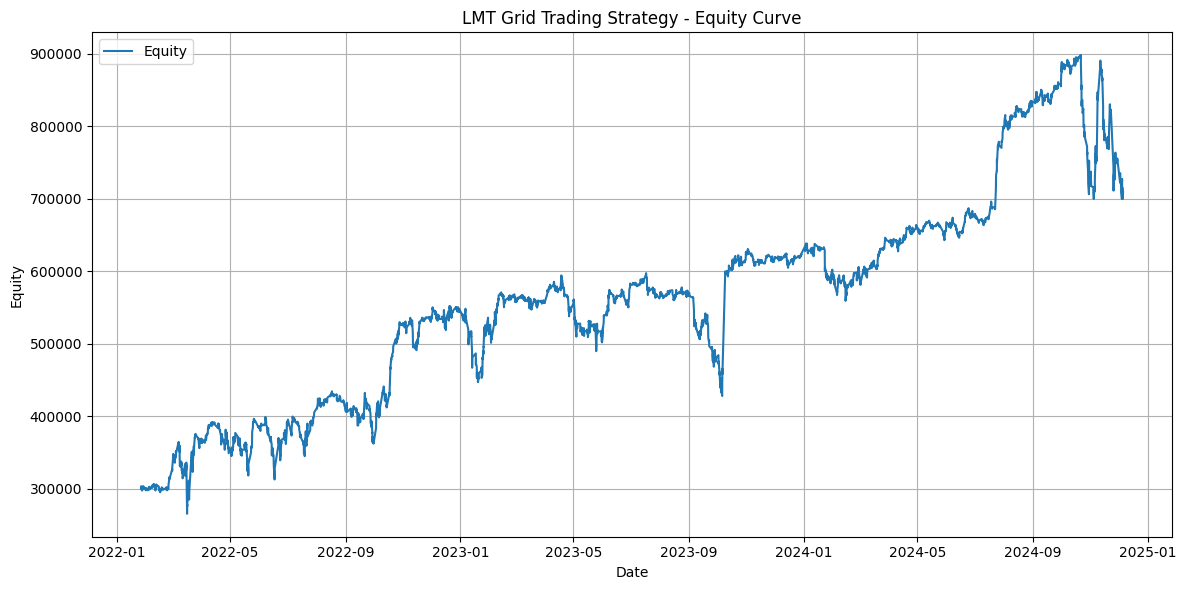

In [40]:
import math

strategyName = "LMT_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_mid-term"
df = getYFinanceData("LMT", "720d", "1h")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.02  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=300000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(15, 25, 1)],
                              grid_size_increment = [i for i in range(1, 20, 1)],
                              maximize='Sharpe Ratio', max_tries=400,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('LMT Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LMT_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term

[*********************100%***********************]  1 of 1 completed


Start                     2016-12-27 00:00:00
End                       2024-12-06 00:00:00
Duration                   2901 days 00:00:00
Exposure Time [%]                        99.9
Equity Final [$]                 250909.50592
Equity Peak [$]                 360171.730652
Return [%]                          736.36502
Buy & Hold Return [%]              104.508502
Return (Ann.) [%]                   30.683837
Volatility (Ann.) [%]               71.143248
Sharpe Ratio                         0.431297
Sortino Ratio                        0.975276
Calmar Ratio                         0.494143
Max. Drawdown [%]                  -62.095033
Avg. Drawdown [%]                   -4.221089
Max. Drawdown Duration      197 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades                                   72
Win Rate [%]                        70.833333
Best Trade [%]                      16.907675
Worst Trade [%]                    -14.678054
Avg. Trade [%]                    

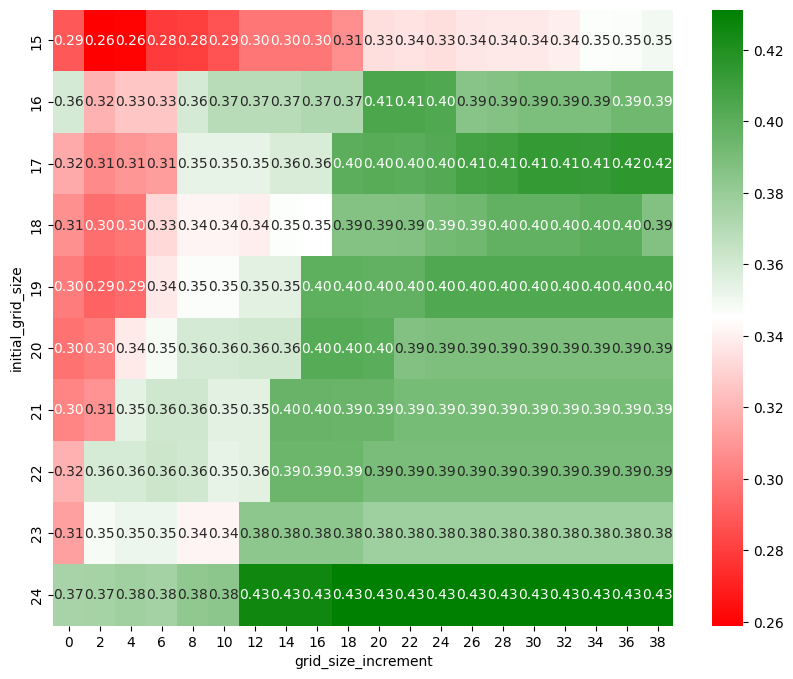

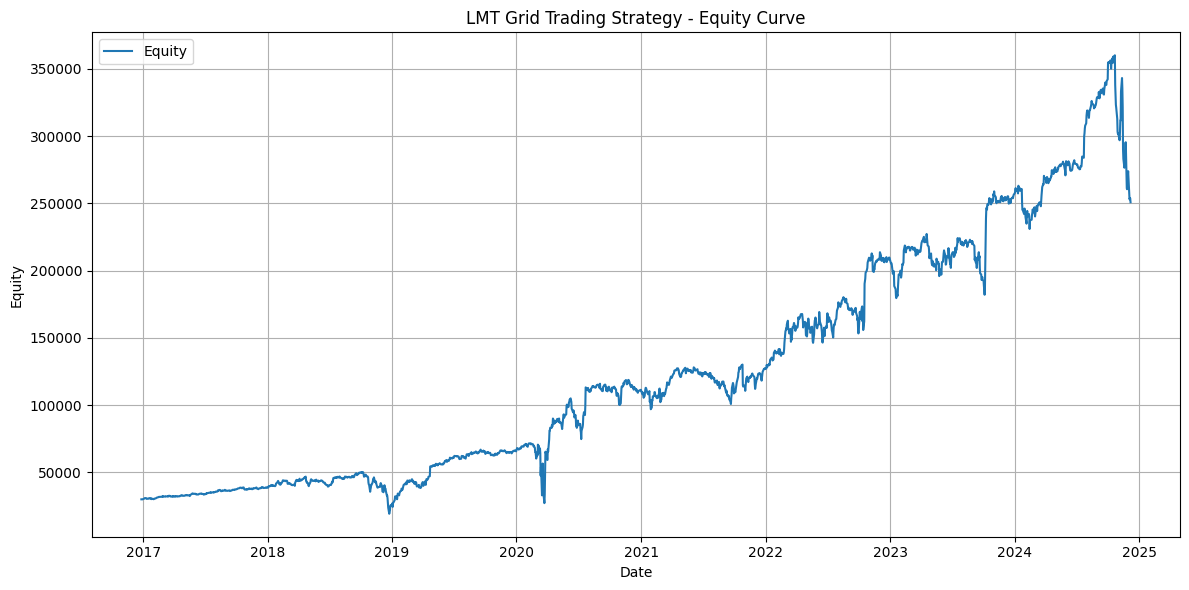

In [13]:
import math

strategyName = "LMT_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("LMT", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.02  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=30000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(15, 25, 1)],
                              grid_size_increment = [i for i in range(0, 40, 2)],
                              maximize='Sharpe Ratio', max_tries=400,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('LMT Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LVMH

[*********************100%***********************]  1 of 1 completed


Start                     2017-02-17 00:00:00
End                       2024-12-06 00:00:00
Duration                   2849 days 00:00:00
Exposure Time [%]                    99.89995
Equity Final [$]                 75861.851028
Equity Peak [$]                 179028.966812
Return [%]                         152.872837
Buy & Hold Return [%]               237.38293
Return (Ann.) [%]                   12.406408
Volatility (Ann.) [%]               55.268969
Sharpe Ratio                         0.224473
Sortino Ratio                        0.425875
Calmar Ratio                         0.172813
Max. Drawdown [%]                  -71.791054
Avg. Drawdown [%]                   -2.909091
Max. Drawdown Duration      267 days 00:00:00
Avg. Drawdown Duration       17 days 00:00:00
# Trades                                  128
Win Rate [%]                         71.09375
Best Trade [%]                      20.848375
Worst Trade [%]                    -29.762458
Avg. Trade [%]                    

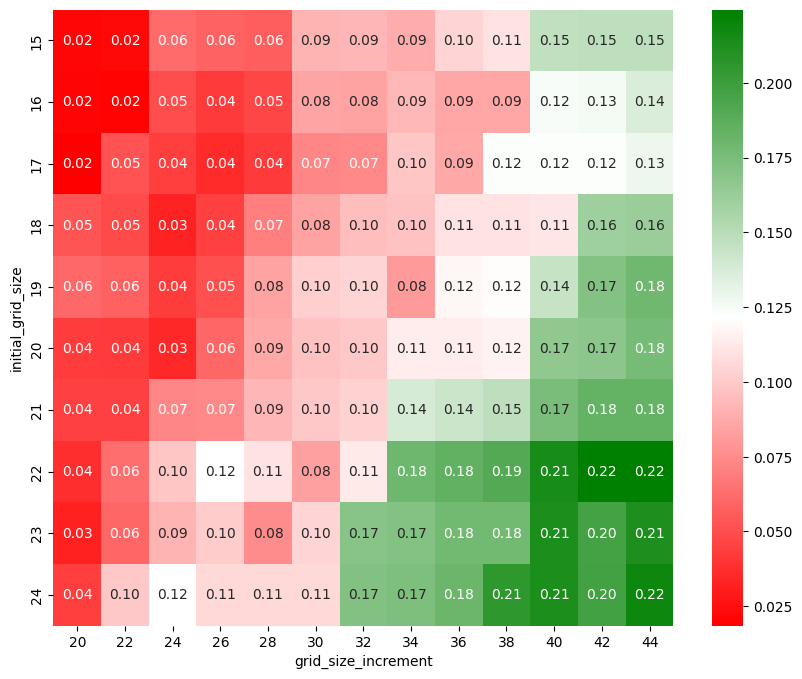

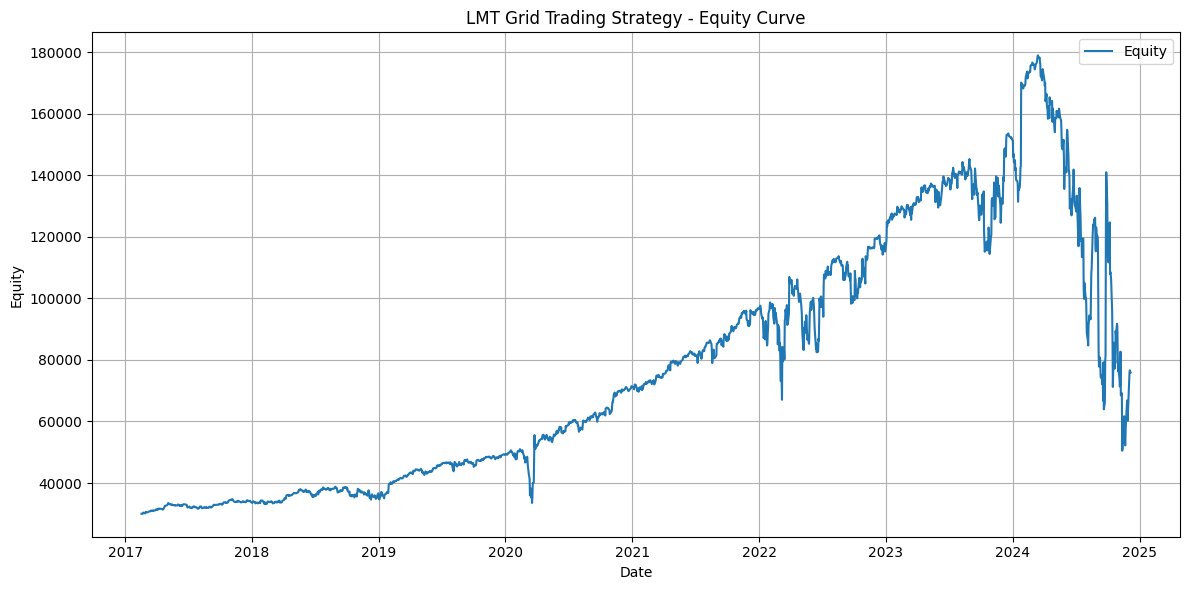

In [16]:
import math

strategyName = "MC.PA_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("MC.PA", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=30000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(15, 25, 1)],
                              grid_size_increment = [i for i in range(20, 46, 2)],
                              maximize='Sharpe Ratio', max_tries=400,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('LMT Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PTT

[*********************100%***********************]  1 of 1 completed


Start                     2016-09-16 00:00:00
End                       2024-12-06 00:00:00
Duration                   3003 days 00:00:00
Exposure Time [%]                   99.896801
Equity Final [$]                 70631.802296
Equity Peak [$]                  74927.802296
Return [%]                         135.439341
Buy & Hold Return [%]               -1.073615
Return (Ann.) [%]                   11.777859
Volatility (Ann.) [%]                36.63088
Sharpe Ratio                         0.321528
Sortino Ratio                        0.628041
Calmar Ratio                         0.239327
Max. Drawdown [%]                  -49.212456
Avg. Drawdown [%]                   -3.899315
Max. Drawdown Duration      472 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                   57
Win Rate [%]                        64.912281
Best Trade [%]                       32.71028
Worst Trade [%]                    -18.857143
Avg. Trade [%]                    

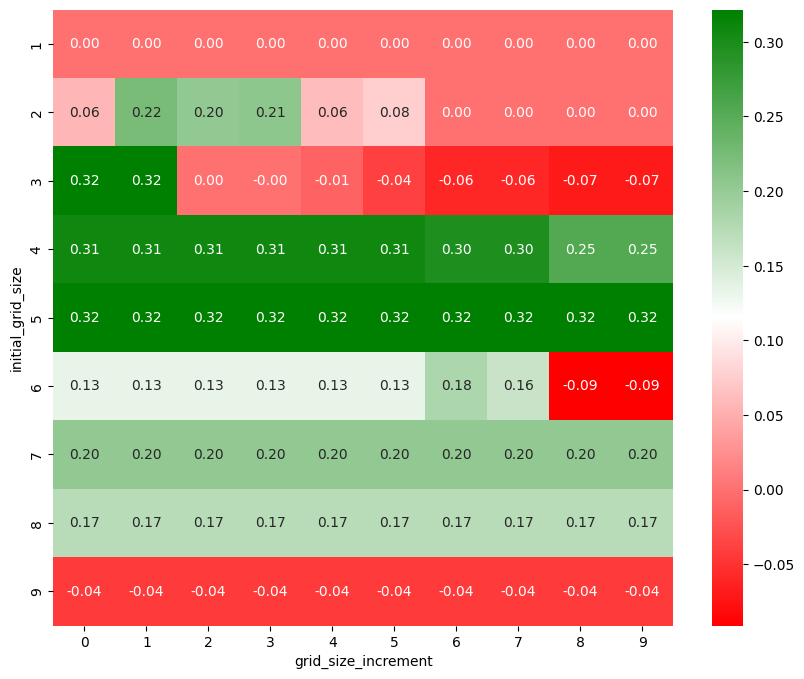

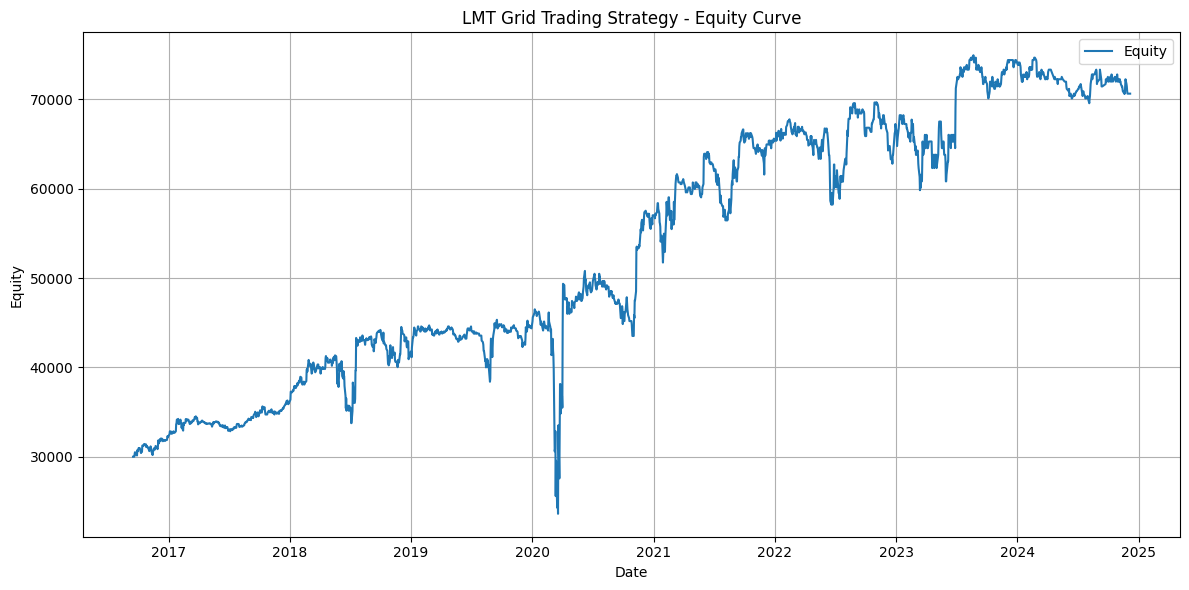

In [21]:
import math

strategyName = "PTT.BK_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("PTT.BK", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=30000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(1, 10, 1)],
                              grid_size_increment = [i for i in range(0, 10, 1)],
                              maximize='Sharpe Ratio', max_tries=400,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('LMT Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### BABA

[*********************100%***********************]  1 of 1 completed


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/backtesting.py:1539: UserWarning: Searching for best of 324 configurations.
  output = _optimize_grid()


Start                     2016-12-27 00:00:00
End                       2024-12-06 00:00:00
Duration                   2901 days 00:00:00
Exposure Time [%]                        99.9
Equity Final [$]                 86212.593075
Equity Peak [$]                  88563.153683
Return [%]                          187.37531
Buy & Hold Return [%]              345.935211
Return (Ann.) [%]                   14.225911
Volatility (Ann.) [%]               18.166103
Sharpe Ratio                         0.783102
Sortino Ratio                        1.315142
Calmar Ratio                         0.637998
Max. Drawdown [%]                  -22.297738
Avg. Drawdown [%]                   -1.968596
Max. Drawdown Duration      539 days 00:00:00
Avg. Drawdown Duration       26 days 00:00:00
# Trades                                   15
Win Rate [%]                             80.0
Best Trade [%]                      51.277239
Worst Trade [%]                    -13.142171
Avg. Trade [%]                    

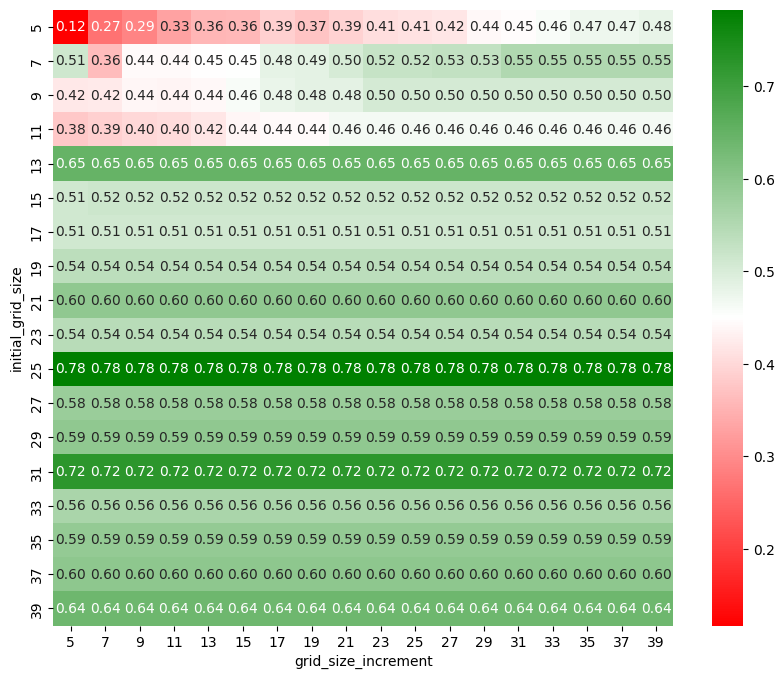

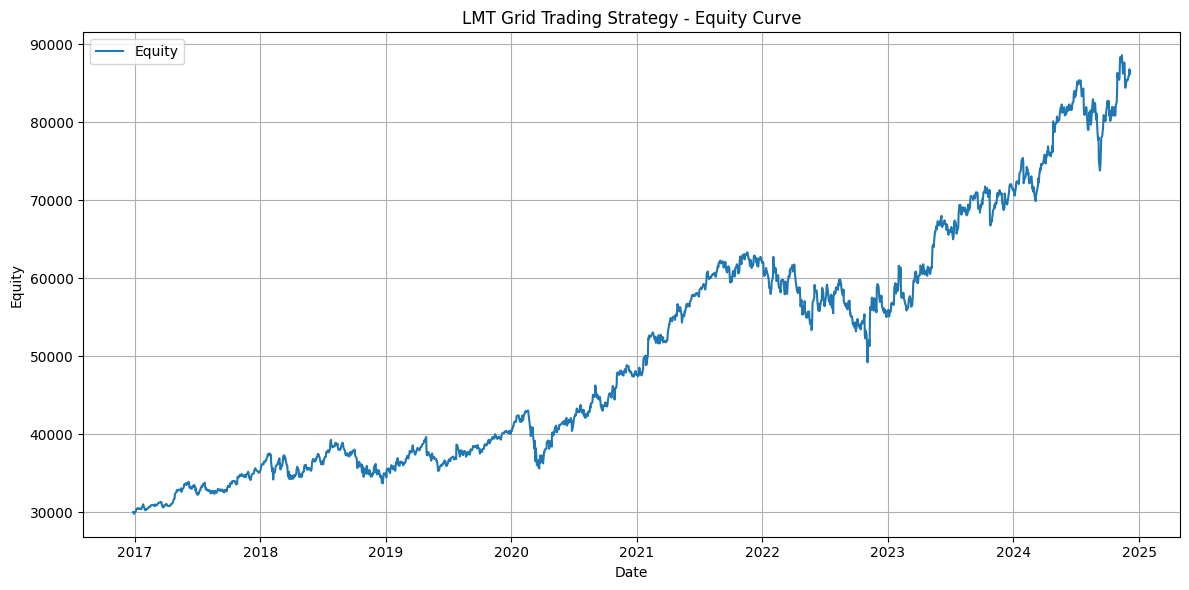

In [28]:
import math

strategyName = "GOOG_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term"
df = getYFinanceData("GOOG", "2000d", "1d")

class GoldGridTrading(Strategy):
    initial_grid_size = 20  # Initial grid size in dollars
    grid_size_increment = 5  # Amount to increase grid size by for each unprofitable trade
    size = 0.01  # Trade size
    
    def init(self):
        super().init()
        self.last_buy_price = None
        self.reset_grid_size()

    def reset_grid_size(self):
        self.current_grid_size = self.initial_grid_size
        self.unprofitable_trades = 0

    def next(self):
        super().next()
        
        current_price = self.data.Close[-1]
        
        # Update grid size based on unprofitable trades
        self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades -2, 0))
        # self.current_grid_size = self.initial_grid_size + (self.grid_size_increment * max(self.unprofitable_trades, 0))
        
        # Check if we should open a new trade
        if self.last_buy_price is None or current_price <= self.last_buy_price - self.current_grid_size:
            adjusted_size = self.size + 0.01 * math.floor(max(self.unprofitable_trades-2, 0))
            self.buy(size=adjusted_size)
            self.last_buy_price = current_price
            self.unprofitable_trades += 1  # Increment unprofitable trades counter
        
        # Check if we should close all trades
        total_profit = sum(trade.pl_pct for trade in self.trades)
        profitable_trades = sum(1 for trade in self.trades if trade.pl_pct > 0)
        
        if (
            (
                profitable_trades >= len(self.trades) / 2 and
                len(self.trades) > 1 and
                total_profit > 0
            ) or 
            (len(self.trades) == 1 and current_price >= self.trades[0].entry_price + self.current_grid_size)
        ):
            for trade in self.trades:
                trade.close()
            self.last_buy_price = None
            self.reset_grid_size()  # Reset grid size after closing all trades in profit
        
# Assuming 'df' is your dataframe with gold price data
bt = Backtest(df, GoldGridTrading, cash=30000, margin=1/50)
stats, heatmap = bt.optimize(
                              initial_grid_size=[i for i in range(5, 40, 2)],
                              grid_size_increment = [i for i in range(5, 40, 2)],
                              maximize='Sharpe Ratio', max_tries=400,
                              random_state=0,
                              return_heatmap=True
                            )
testResults[strategyName] = {
    "stats": stats,
    "heatmap": heatmap,
    "bt": bt,
    "best_grid_size": stats._strategy.initial_grid_size,
    "best_grid_size_increment": stats._strategy.grid_size_increment,
}

print(stats)

# Plot the Heatmap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap=cmap, fmt='.2f')
plt.show()

# Plot the equity curve
bt.plot(filename=strategyName+".html", resample=False)

# If you prefer a static plot using matplotlib:
plt.figure(figsize=(12, 6))
plt.plot(stats._equity_curve.index, stats._equity_curve.Equity, label='Equity')
plt.title('LMT Grid Trading Strategy - Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary

In [42]:


# Assuming testResults is a dictionary where each key maps to a stat object
# Example: testResults = {'test1': stat1, 'test2': stat2, ...}

# Initialize an empty list to store the summary data
summary_data = []

# Iterate over the keys in testResults
for key in testResults.keys():
    # Extract the stat object
    stat = testResults[key]['stats']
    
    # Extract relevant statistics from the stat object
    # Adjust these lines based on the actual attributes of your stat object
    summary = {
        'Test': key,
        'Total Return [%]': stat['Return [%]'],
        'Max. Drawdown [%]': stat['Max. Drawdown [%]'],
        'Avg. Drawdown [%]': stat['Avg. Drawdown [%]'],
        'Sharpe Ratio': stat['Sharpe Ratio'],
        'Trades': stat['# Trades'],
        'Grid Size': testResults[key]['best_grid_size'],
        'Grid Increment': testResults[key].get('best_grid_size_increment', None)
    }
    
    # Append the summary to the list
    summary_data.append(summary)

# Convert the list of summaries to a DataFrame
summary_df = pd.DataFrame(summary_data)

# don't truncate the column header text
pd.set_option('display.max_colwidth', None)
# Display the summary DataFrame
(summary_df)

,Test,Total Return [%],Max. Drawdown [%],Avg. Drawdown [%],Sharpe Ratio,Trades,Grid Size,Grid Increment
0,GC=F_maximize-sharpe_all-breakeven,237.603311,-27.224521,-1.196662,0.954355,552,28,NaN
1,GC=F_minimize-drawdown_all-profitable,143.765728,-21.614090,-0.966886,1.049259,522,48,NaN
2,GC=F_maximize-sharpe_net-profitable,92.523994,-12.506128,-0.578458,1.280668,98,40,NaN
3,GC=F_maximize-sharpe_net-profitable_increasing-grid-size,76.658451,-14.069208,-0.625877,1.171472,83,24,15.0
4,GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term,163.439511,-30.629236,-1.705002,0.708240,188,29,13.0
5,^SPX_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term,192.711714,-35.685257,-1.255215,0.503338,65,170,60.0
6,GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_mid-term,372.346414,-25.636395,-1.123722,1.153391,263,24,12.0
7,^SPX_maximize-sharpe_net-profitable_increasing-grid-size,48.882906,-22.233574,-0.589122,0.811201,34,170,60.0
8,BTC-USD_maximize-sharpe_net-profitable_increasing-grid-size,376.997518,-40.510819,-1.336502,1.065231,114,1600,800.0
9,LMT_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_mid-term,136.269557,-28.350560,-2.510186,0.625119,72,17,3.0


/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/193110123.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spx_daily = df_spx.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/193110123.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_gc_daily = df_gc.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/193110123.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_lmt_daily = df_lmt.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/193110123.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and wi

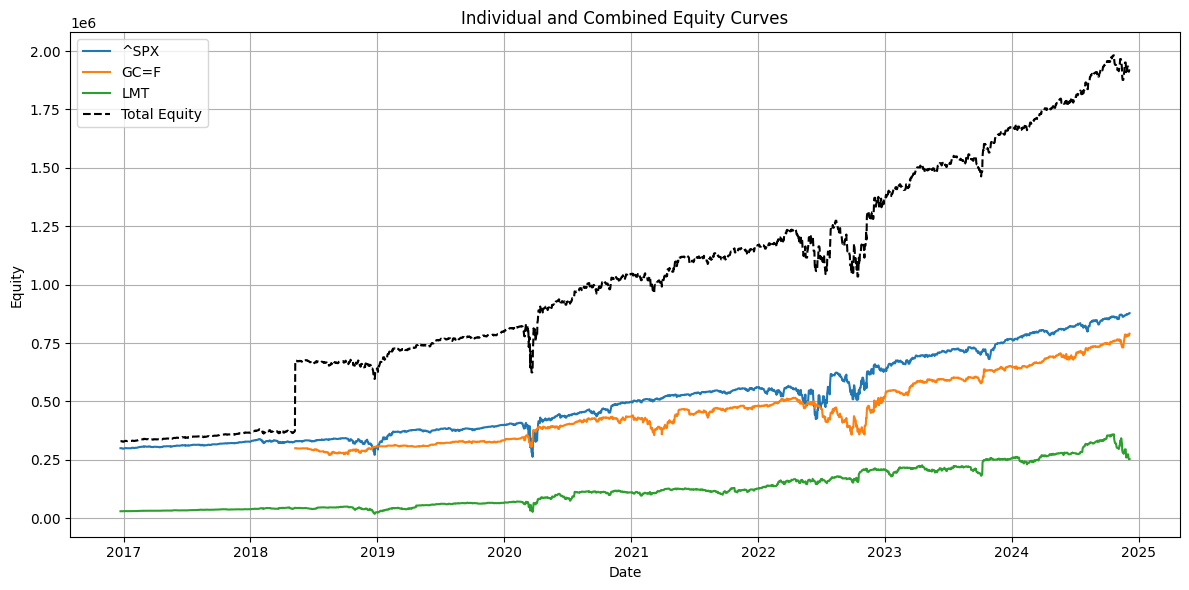

Start Date: 2016-12-23 00:00:00
End Date: 2024-12-05 00:00:00
Total Days: 2905
Final ^SPX Equity: 878135.1420898438
Final GC=F Equity: 790318.5338134766
Final LMT Equity: 253318.45681762695
Final Total Equity: 1921772.1327209473


In [43]:
# Extract the equity curves
equity_curve_spx = testResults['^SPX_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term']['stats']['_equity_curve']['Equity']
equity_curve_gc = testResults['GC=F_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term']['stats']['_equity_curve']['Equity']
equity_curve_lmt = testResults['LMT_maximize-sharpe_net-profitable_increasing-grid-size-and-position-size_long-term']['stats']['_equity_curve']['Equity']
# equity_curve_btc = testResults['BTC-USD_maximize-sharpe_net-profitable_increasing-grid-size']['stats']['_equity_curve']['Equity']

# Convert to DataFrames with DateTimeIndex
df_spx = pd.DataFrame(equity_curve_spx)
df_gc = pd.DataFrame(equity_curve_gc)
df_lmt = pd.DataFrame(equity_curve_lmt)
# df_btc = pd.DataFrame(equity_curve_btc)

# Resample both series to a common frequency (e.g., daily)
df_spx_daily = df_spx.resample('D').last().fillna(method='ffill')
df_gc_daily = df_gc.resample('D').last().fillna(method='ffill')
df_lmt_daily = df_lmt.resample('D').last().fillna(method='ffill')
# df_btc_daily = df_btc.resample('D').last().fillna(method='ffill')

# Align the two DataFrames on their index and fill missing values
combined_equity_curve = pd.concat([
  df_spx_daily,
  df_gc_daily,
  df_lmt_daily,
  # df_btc_daily
], axis=1, join='outer').fillna(method='ffill')
combined_equity_curve.columns = [
  '^SPX',
  'GC=F',
  'LMT',
  # 'BTC-USD'
]

# Calculate the sum of the equity curves
combined_equity_curve['Total Equity'] = combined_equity_curve.sum(axis=1)

# Plot the individual and combined equity curves
plt.figure(figsize=(12, 6))
plt.plot(combined_equity_curve.index, combined_equity_curve['^SPX'], label='^SPX')
plt.plot(combined_equity_curve.index, combined_equity_curve['GC=F'], label='GC=F')
plt.plot(combined_equity_curve.index, combined_equity_curve['LMT'], label='LMT')
plt.plot(combined_equity_curve.index, combined_equity_curve['Total Equity'], label='Total Equity', linestyle='--', color='black')
plt.title('Individual and Combined Equity Curves')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some statistics
print("Start Date:", combined_equity_curve.index[0])
print("End Date:", combined_equity_curve.index[-1])
print("Total Days:", len(combined_equity_curve))
print("Final ^SPX Equity:", combined_equity_curve['^SPX'].iloc[-1])
print("Final GC=F Equity:", combined_equity_curve['GC=F'].iloc[-1])
print("Final LMT Equity:", combined_equity_curve['LMT'].iloc[-1])
print("Final Total Equity:", combined_equity_curve['Total Equity'].iloc[-1])

/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1214460775.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spx_daily = df_spx.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1214460775.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_gc_daily = df_gc.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1214460775.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_lmt_daily = df_lmt.resample('D').last().fillna(method='ffill')
/var/folders/mb/tyl8xvh9689bgk14qr31lc7r0000gn/T/ipykernel_2857/1214460775.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and w

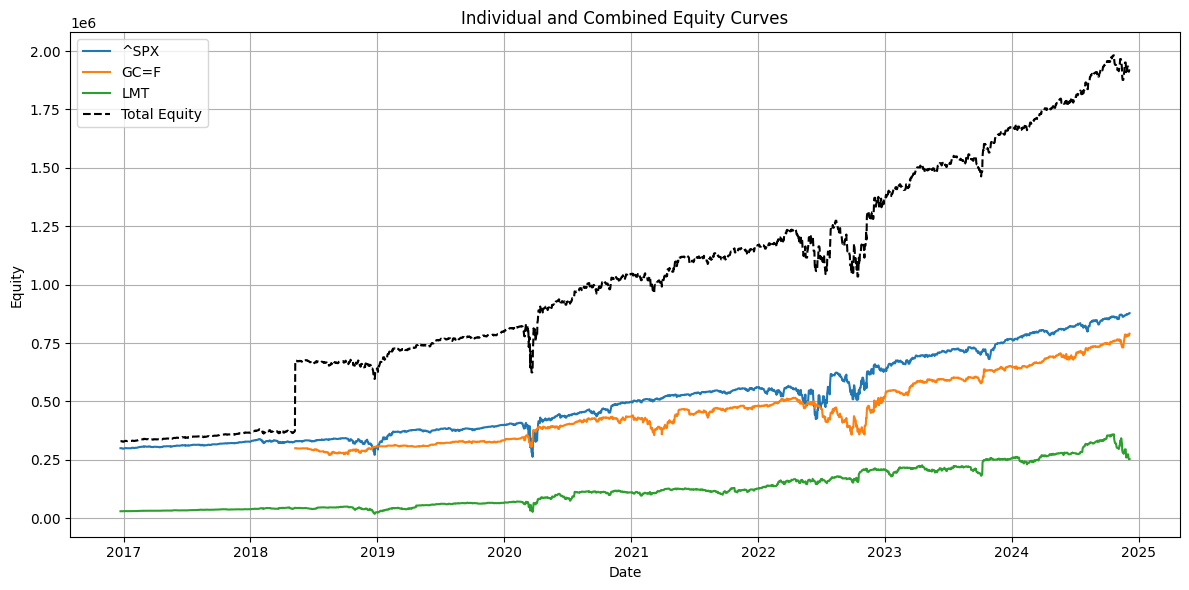

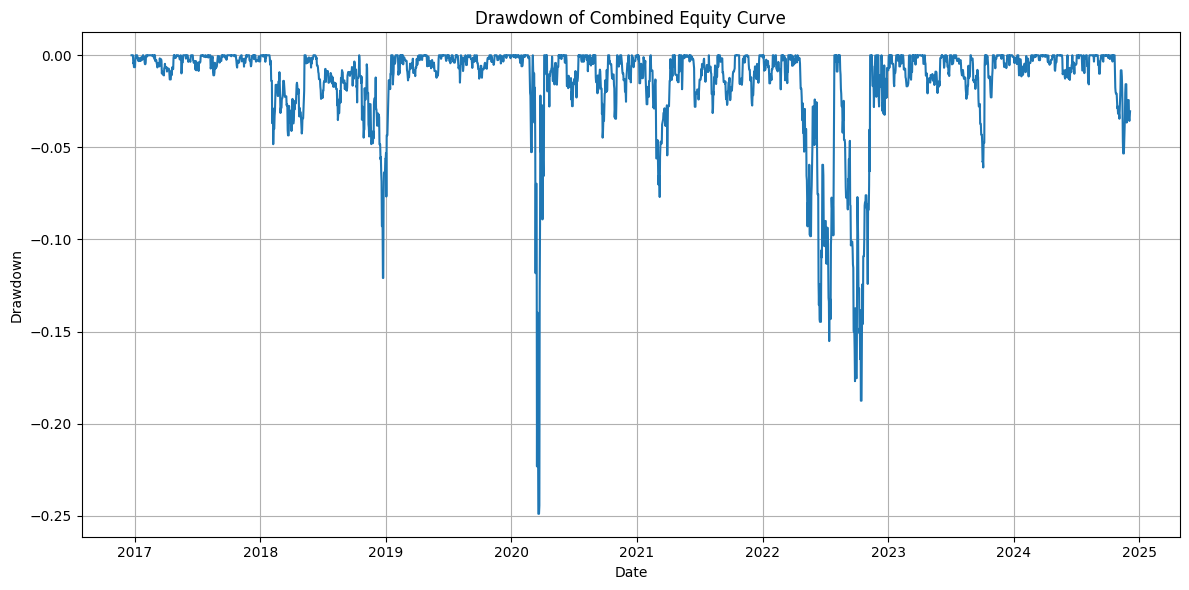

Start Date: 2016-12-23 00:00:00
End Date: 2024-12-05 00:00:00
Total Days: 2905
Final ^SPX Equity: 878135.1420898438
Final GC=F Equity: 790318.5338134766
Final LMT Equity: 253318.45681762695
Final Total Equity: 1921772.1327209473
Average Drawdown: -1.46%
Maximum Drawdown: -24.90%
Maximum Drawdown Duration: 127 days
Average Drawdown Duration: 22.09 days
Average Recovery Time: 11.45 days
Maximum Recovery Time: 127 days


In [44]:
# Convert to DataFrames with DateTimeIndex
df_spx = pd.DataFrame(equity_curve_spx)
df_gc = pd.DataFrame(equity_curve_gc)
df_lmt = pd.DataFrame(equity_curve_lmt)

# Resample both series to a common frequency (e.g., daily)
df_spx_daily = df_spx.resample('D').last().fillna(method='ffill')
df_gc_daily = df_gc.resample('D').last().fillna(method='ffill')
df_lmt_daily = df_lmt.resample('D').last().fillna(method='ffill')

# Align the two DataFrames on their index and fill missing values
combined_equity_curve = pd.concat([df_spx_daily, df_gc_daily, df_lmt_daily], axis=1, join='outer').fillna(method='ffill')
combined_equity_curve.columns = ['^SPX', 'GC=F', 'LMT']

# Calculate the sum of the equity curves
combined_equity_curve['Total Equity'] = combined_equity_curve.sum(axis=1)

# Calculate drawdown
combined_equity_curve['Peak'] = combined_equity_curve['Total Equity'].cummax()
combined_equity_curve['Drawdown'] = (combined_equity_curve['Total Equity'] - combined_equity_curve['Peak']) / combined_equity_curve['Peak']

# Calculate average drawdown and maximum drawdown
average_drawdown = combined_equity_curve['Drawdown'].mean()
max_drawdown = combined_equity_curve['Drawdown'].min()

# Plot the individual and combined equity curves
plt.figure(figsize=(12, 6))
plt.plot(combined_equity_curve.index, combined_equity_curve['^SPX'], label='^SPX')
plt.plot(combined_equity_curve.index, combined_equity_curve['GC=F'], label='GC=F')
plt.plot(combined_equity_curve.index, combined_equity_curve['LMT'], label='LMT')
plt.plot(combined_equity_curve.index, combined_equity_curve['Total Equity'], label='Total Equity', linestyle='--', color='black')
plt.title('Individual and Combined Equity Curves')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the drawdown
plt.figure(figsize=(12, 6))
plt.plot(combined_equity_curve.index, combined_equity_curve['Drawdown'])
plt.title('Drawdown of Combined Equity Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print statistics
print("Start Date:", combined_equity_curve.index[0])
print("End Date:", combined_equity_curve.index[-1])
print("Total Days:", len(combined_equity_curve))
print("Final ^SPX Equity:", combined_equity_curve['^SPX'].iloc[-1])
print("Final GC=F Equity:", combined_equity_curve['GC=F'].iloc[-1])
print("Final LMT Equity:", combined_equity_curve['LMT'].iloc[-1])
print("Final Total Equity:", combined_equity_curve['Total Equity'].iloc[-1])
print(f"Average Drawdown: {average_drawdown:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Calculate and print additional drawdown statistics
drawdown_series = combined_equity_curve['Drawdown']
drawdown_duration = drawdown_series[drawdown_series < 0].groupby((drawdown_series >= 0).cumsum()).cumcount() + 1
max_drawdown_duration = drawdown_duration.max()
average_drawdown_duration = drawdown_duration.mean()

print(f"Maximum Drawdown Duration: {max_drawdown_duration} days")
print(f"Average Drawdown Duration: {average_drawdown_duration:.2f} days")

# Calculate and print recovery statistics
recovery_times = []
in_drawdown = False
drawdown_start = None

for date, value in drawdown_series.items():
    if not in_drawdown and value < 0:
        in_drawdown = True
        drawdown_start = date
    elif in_drawdown and value == 0:
        in_drawdown = False
        recovery_time = (date - drawdown_start).days
        recovery_times.append(recovery_time)

if recovery_times:
    average_recovery_time = np.mean(recovery_times)
    max_recovery_time = max(recovery_times)
    print(f"Average Recovery Time: {average_recovery_time:.2f} days")
    print(f"Maximum Recovery Time: {max_recovery_time} days")
else:
    print("No complete recovery periods found in the data.")